# Process the Hydrographic Data into Parquet

The NOAA National Water Model Retrospective dataset is a 44-year (February 1979 through January 2023) retrospective simulation using version 3.0 of the National Water Model. This is hourly streamflow data from all streams and rivers in the U.S. by `COMID` (feature id) id. We will be subsetting streams by HUC-2 Regions.  The COMID ids will be extracted from shapefiles for the HUC-2 region and saved as a parquet file (more efficient = smaller than csv). This file will be read in later when the feature ids are needed. 

## HUC-2 Region 18: California

Region 18 covers the state of California, encompassing a wide range of hydrologic systems including coastal rivers, inland terminal basins, and desert watersheds. It includes streams that flow directly to the Pacific Ocean, as well as closed basins (e.g., Mono Lake, Owens Valley) and desert drainages that may reach the Gulf of California. The region spans from northwestern coastal forests to southern arid zones.

## Source and Description of Hydrography Data

The shapefile used in this project is derived from the [EPA NHDPlus Version 2.1 California Data (Vector Processing Unit 18)](https://www.epa.gov/waterdata/nhdplus-california-data-vector-processing-unit-18), specifically from the archive: `NHDPlusV21_CA_18_NHDSnapshot_05.7z`.

This archive contains a snapshot of the National Hydrography Dataset (NHD) flowlines for Hydrologic Region 18 (HUC-2). The NHDPlusV2.1 dataset integrates high-resolution stream and river centerlines with attributes such as:

- `COMID` (unique feature ID)
- `FTYPE` (e.g., StreamRiver, CanalDitch, ArtificialPath)
- `LENGTHKM` (feature length in kilometers)
- `REACHCODE` (hierarchical hydrologic code the first 4 digits of which are the HUC-4 code)
- `GNIS_NAME` (official stream name)

## HUC-4 Subregions Included in VPU 18

`NHDPlusV21_CA_18_NHDSnapshot_05.7z` represents Hydrologic Region 18 (HUC-2), primarily covering California’s coastal drainage basins, but some additional subregions are included. The two subregions from other HUC-2 regions (1606 and 1712) are in the archive and were removed as they are not part of HUC-2 region 18.


| HUC-4 | Name                   | Region Description                                     |
|-------|------------------------|--------------------------------------------------------|
| 1801  | Smith River–Klamath    | NW California coastal rivers flowing to Pacific       |
| 1802  | Mad–Redwood            | Coastal watersheds flowing to Pacific                           |
| 1803  | Eel                    | Coastal watershed flowing to Pacific                   |
| 1804  | Russian                | Coastal watershed flowing to Pacific                     |
| 1805  | Bodega–Tomales         | Small coastal drainages flowing to Pacific                              |
| 1806  | San Francisco Bay      | San Francisco Bay flows to Pacific            |
| 1807  | Central Coastal        | Monterey Bay and surrounding coastal watersheds       |
| 1808  | Southern Coastal CA (San Diego) | Flows to Pacific                   |
| 1809  | Salinas                | Flows into Monterey Bay and then to Pacific | 
| 1810  | Lower Colorado / Imperial Valley| Flows to Gulf of California, not the Pacific Ocean — part of Region 18 but hydrologically separate |
| 1606  | Smith River / Lower Klamath     | Drains to the Pacific, but part of Region 16 (Pacific Northwest) — not Region 18; not included             |
| 1712  | Owens River / Mono Lake   | Terminal basin (no outflow to ocean); flows into dry lakebeds; not included                          |



*Acknowledgment: Data provided by the U.S. Environmental Protection Agency (EPA) and U.S. Geological Survey (USGS) as part of the NHDPlusV2 dataset.*

## Data aquisition

The zip file `NHDPlusV21_CA_18_NHDSnapshot_05.7z` was downloaded, unzipped and these files in the Hydrography directory were kept: NHDFlowline.shp, NHDFlowline.dbf, NHDFlowline.shx, NHDFlowline.prj, NHDFlowline.shp.xml.

First I will convert to a geoparquet file which will be more efficient space-wise. I will keep this with the processed streamflow data for completeness. If I were only working with Python, the following code would work, but R is really picky with the geometries and I had to really flatten the geometry to get R to use the parquet file.


In [27]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Measured \\(M\\) geometry types are not supported.*",
    category=UserWarning,
    module="pyogrio.raw"
)
import geopandas as gpd

gdf = gpd.read_file("../HUC2-18/NHDFlowline.shp")

In [24]:
# This would work fine for Python
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str[:4]

# Exclude 1606 and 1712; these are not in Region 18
gdf_filtered = gdf[~gdf["HUC4"].isin(["1606", "1712"])]

# Save to Parquet
gdf_filtered.to_parquet("../flowline/WR_18_Flowline.parquet", index=False)

In [25]:
# But R complains about malformed geometries so I had to get ChatGPT to help
# me make the geometry 2D
import geopandas as gpd
from shapely.geometry import (
    Point, LineString, Polygon,
    MultiPoint, MultiLineString, MultiPolygon,
)
from shapely.geometry.base import BaseGeometry

def drop_z_coords(geom: BaseGeometry):
    if geom.is_empty or geom is None:
        return geom

    if isinstance(geom, Point):
        return Point(geom.x, geom.y)

    elif isinstance(geom, LineString):
        return LineString([(x, y) for x, y, *_ in geom.coords])

    elif isinstance(geom, Polygon):
        exterior = [(x, y) for x, y, *_ in geom.exterior.coords]
        interiors = [
            [(x, y) for x, y, *_ in ring.coords]
            for ring in geom.interiors
        ]
        return Polygon(exterior, interiors)

    elif isinstance(geom, MultiPoint):
        return MultiPoint([drop_z_coords(g) for g in geom.geoms])

    elif isinstance(geom, MultiLineString):
        return MultiLineString([drop_z_coords(g) for g in geom.geoms])

    elif isinstance(geom, MultiPolygon):
        return MultiPolygon([drop_z_coords(g) for g in geom.geoms])

    else:
        raise ValueError(f"Unsupported geometry type: {type(geom)}")

gdf["geometry"] = gdf["geometry"].apply(drop_z_coords)

# Save clean 2D geometry
gdf.to_parquet("../flowline/WR_18_Flowline.parquet", index=False)


<Axes: >

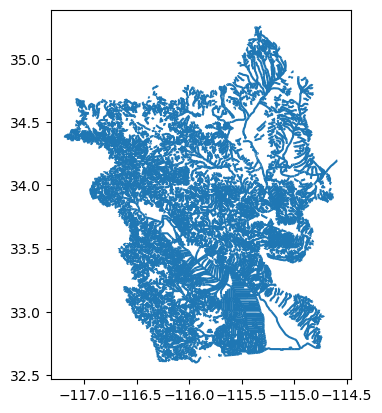

In [26]:
# test
import geopandas as gpd
gdf = gpd.read_parquet("../flowline/WR_18_Flowline.parquet")
gdf_small = gdf[gdf["HUC4"] == "1810"]
gdf_small.plot()


## Create a map

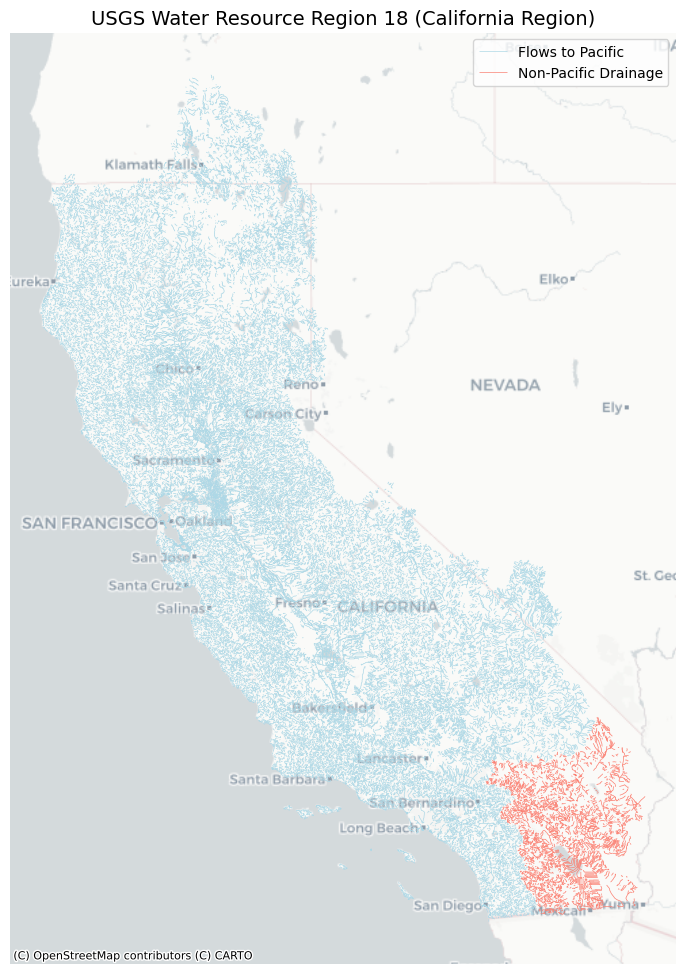

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the GeoParquet file
gdf = gpd.read_parquet("../flowline/WR_18_Flowline.parquet")

# Set CRS if missing
if gdf.crs is None:
    gdf.set_crs("ESRI:102039", inplace=True)

# Clean up geometries
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

# Reproject
gdf = gdf.to_crs("EPSG:3857")

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str.slice(0, 4)

# Separate those two HUC-4s
non_pacific = gdf[gdf["HUC4"].isin(["1810"])]
rest = gdf[~gdf["HUC4"].isin(["1810"])]

# Optional: sample for plotting efficiency
rest_sampled = rest.sample(frac=0.5, random_state=42)
non_pacific_sampled = non_pacific.sample(frac=0.5, random_state=42)

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
rest_sampled.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.5, label="Flows to Pacific")
non_pacific_sampled.plot(ax=ax, color="salmon", edgecolor="black", linewidth=0.5, label="Non-Pacific Drainage")

ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title("USGS Water Resource Region 18 (California Region)", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()

plt.savefig("../metadata/wr18_map.png", dpi=300, bbox_inches="tight")
plt.show()


## Save the data frame of feature ids

In [29]:
import geopandas as gpd

gdf = gpd.read_parquet("../flowline/WR_18_Flowline.parquet")

# Drop geometry if you don't need it
df = gdf.drop(columns="geometry")

df.to_parquet("../flowline/WR_18_metadata.parquet")

In [30]:
df

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,HUC4
0,20245062,1999-11-24,Medium,None,None,5.415,16060014044574,Uninitialized,0,StreamRiver,46003,0.051485,True,0,1606
1,24085230,2001-02-27,Medium,None,None,2.787,17120005008721,Uninitialized,0,StreamRiver,46003,0.029709,True,0,1712
2,22226684,1999-08-10,Medium,253899,Smith River,0.598,18010101000020,With Digitized,0,StreamRiver,46006,0.005781,True,0,1801
3,22226720,1999-08-10,Medium,253899,Smith River,2.855,18010101000021,With Digitized,0,StreamRiver,46006,0.028091,True,0,1801
4,22226732,1999-08-10,Medium,253899,Smith River,0.807,18010101000023,With Digitized,0,StreamRiver,46006,0.008401,True,0,1801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178863,948100338,2010-12-01,Medium,None,None,6.585,18100204012853,With Digitized,948100002,ArtificialPath,55800,0.000000,True,0,1810
178864,948100464,1999-12-29,Medium,238524,All American Canal,3.912,18100204012854,Uninitialized,0,CanalDitch,33600,0.239505,True,0,1810
178865,948100356,2002-04-03,Medium,None,None,0.681,18100204012855,With Digitized,0,StreamRiver,46003,0.000000,True,0,1810
178866,948100357,2002-04-03,Medium,None,None,3.951,18100204012856,With Digitized,0,StreamRiver,46003,0.000000,True,0,1810


## Test that it reads in ok

In [31]:
import pandas as pd

# Load the full parquet file
df = pd.read_parquet("../flowline/WR_18_metadata.parquet")

# Filter where FTYPE is exactly "StreamRiver"
streamriver_df = df[df["FTYPE"] == "StreamRiver"]

# Extract COMIDs (aka feature_ids)
feature_ids = streamriver_df["COMID"].unique()

len(feature_ids)

135802

## Summary 

The original shapefiles were processed into a geoparquet that is smaller in size. A parquet file with just the COMID id metadata is saved also as parquet file. These files will appear in the GCP bucket as follows.